## dataset path setting

In [2]:
# Justice data path
justice_path = './dataset/'

## import libraries

In [4]:
# imports
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

## read data

In [5]:
df = pd.read_pickle(os.path.join(justice_path,'justice_data.pkl'))
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

print(f'There are {len(df)} cases.')

There are 3464 cases.


## download nltk data

In [6]:
# down load nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# setting stopword
stop = stopwords.words('english')
stop.remove('no')
stop.remove('not')

# setting lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/robert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## data clean

In [7]:
def data_clean(fact):
    """This is to clean the facts. Will remove the first party and second party name

    Args:
        first_party:    first party name
        second_party:   second party name
        fact:           fact text

    return:
        cleaned fact"""
    # 1. lower-case for the text, also remove some punctuations

    fact_text = fact.lower().replace(',', '')
    fact_text = fact_text.replace('<p>', '')
    fact_text = fact_text.replace('</p>\n', '')
    # print(fact_text)

    # 2. replace/remove the name of the first party and second party

    #fact_split = ' '.join([x for x in fact_text.split(' ') if x not in first_second_party])

    # 3. remove punctuations and numbers
    fact_clean = re.sub('[^a-zA-Z]', ' ', fact_text)

    # 4. remove single character
    fact_clean = re.sub(r"\s+[a-zA-Z]\s+", ' ', fact_clean)

    # 5. remove multiple spaces
    fact_clean = re.sub(r'\s+', ' ', fact_clean)

    # 6. token
    fact_clean = word_tokenize(fact_clean)

    # 7. remove stop words
    fact_clean = [word for word in fact_clean if word not in (stop)]

    # 8. lemmatizer
    fact_clean = [lemmatizer.lemmatize(word) for word in fact_clean]

    # join token to text
    fact_clean = ' '.join(fact_clean)


    return fact_clean

In [8]:
df['cleaned facts'] = df.apply(lambda x: data_clean(x.facts), axis=1)

## TF-IDF vectorization and category labelling

In [9]:
# TF-IDF
vectorizer_facts = TfidfVectorizer()
vectorizer_clean_facts = vectorizer_facts.fit_transform(df['cleaned facts'])
facts_clean_array = vectorizer_clean_facts.toarray()

In [10]:
# cateogry labelling
label_encoder = preprocessing.LabelEncoder()
data_label = label_encoder.fit_transform(df['winner_index'])

## Data augmentation and balancing

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
facts_clean_array_re,data_label_re=smote.fit_resample(facts_clean_array,data_label)

## Data split for train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(facts_clean_array_re, data_label_re, test_size=0.2,random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3382, 14713) (846, 14713) (3382,) (846,)


In [14]:
input_length = 200
word_nums = X_train.shape[1]//input_length
print(X_train[:, 0:input_length*word_nums].shape)
X_train_reshape = X_train[:,0:input_length*word_nums].reshape((-1,input_length,word_nums))
X_test_reshape = X_test[:,0:input_length*word_nums].reshape((-1,input_length,word_nums))
print(X_train_reshape.shape, X_test_reshape.shape)

(3382, 14600)
(3382, 200, 73) (846, 200, 73)


## build model

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(256,5, activation='relu', input_shape=(input_length, word_nums)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Conv1D(128,3,activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Conv1D(64,5,activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## model training

In [16]:
history=model.fit(X_train_reshape, y_train, epochs=20, validation_data=(X_test_reshape, y_test), batch_size=128)

Epoch 1/20
27/27 [==============================] - 11s 366ms/step - loss: 0.6862 - accuracy: 0.5618 - val_loss: 0.6598 - val_accuracy: 0.6348
Epoch 2/20
27/27 [==============================] - 10s 360ms/step - loss: 0.6098 - accuracy: 0.6759 - val_loss: 0.5464 - val_accuracy: 0.7506
Epoch 3/20
27/27 [==============================] - 10s 351ms/step - loss: 0.4369 - accuracy: 0.8176 - val_loss: 0.3869 - val_accuracy: 0.8452
Epoch 4/20
27/27 [==============================] - 8s 288ms/step - loss: 0.2698 - accuracy: 0.9066 - val_loss: 0.3013 - val_accuracy: 0.8865
Epoch 5/20
27/27 [==============================] - 8s 290ms/step - loss: 0.1484 - accuracy: 0.9548 - val_loss: 0.2075 - val_accuracy: 0.9243
Epoch 6/20
27/27 [==============================] - 8s 292ms/step - loss: 0.0726 - accuracy: 0.9837 - val_loss: 0.1522 - val_accuracy: 0.9515
Epoch 7/20
27/27 [==============================] - 9s 352ms/step - loss: 0.0377 - accuracy: 0.9941 - val_loss: 0.1371 - val_accuracy: 0.9492
Epo

## model testing

In [17]:
classifications= model.predict(X_test_reshape)
pred_test = classifications.argmax(axis=1)
accuracy_score(y_true=y_test, y_pred=pred_test)

27/27 [==============================] - 1s 17ms/step


0.9633569739952719

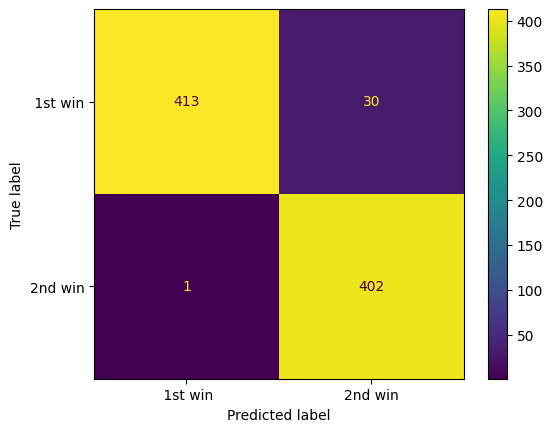

In [18]:

Con_matrix=confusion_matrix(y_test, pred_test)
classes =[" 1st win","2nd win"]
disp = ConfusionMatrixDisplay(confusion_matrix=Con_matrix, display_labels=classes)
disp.plot(
    include_values=True,
    cmap='viridis',
    ax=None,
    xticks_rotation='horizontal',
    values_format='d'
)
plt.show()

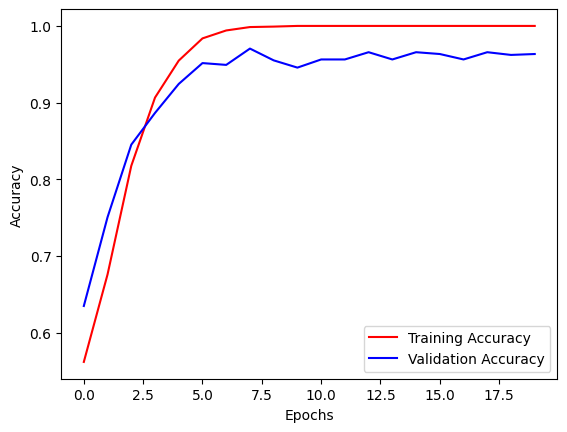

In [19]:
train_acc_history = history.history['accuracy']
test_acc_history = history.history['val_accuracy']
plt.plot(train_acc_history,c='r')
plt.plot(test_acc_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()